# SentiMix Hindi-English

[Competition Link](https://competitions.codalab.org/competitions/20654)

[Preprocessed Training Set](https://drive.google.com/file/d/1VJwEz8Er32HVU9cRT0KE6_aQ57Zk1KHn/view?usp=sharing)

[Preprocessed Test Set](https://drive.google.com/file/d/1fEStOFdGeowWemE0uw_UOm9TfeTcxmbh/view?usp=sharing) 

## Setup

In [ ]:
!pip install transformers

In [ ]:
import os
import json
import math
import random
import transformers

import regex as re
import numpy as np
import pandas as pd

from matplotlib import style
from google.colab import drive
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, classification_report

import torch
from torch import tensor
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification, AdamW, Adafactor, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

style.use('dark_background')

In [ ]:
# Useful paths
DRIVE_DIR = '/content/drive'
DATA_DIR = os.path.join(DRIVE_DIR, 'My Drive/sentimix')
TRAIN_DATA_PATH = os.path.join(DATA_DIR, 'train_set_without_usernames.json')
TEST_DATA_PATH = os.path.join(DATA_DIR, 'test_set_without_usernames.json')

In [ ]:
# Mounting drive
from google.colab import drive

drive.mount(DRIVE_DIR)
%cd $DATA_DIR

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1mNIgpMsgysDwuZSrrcFW0VHemZmuiHA8/sentimix


## Loading Datasets

In [ ]:
# Loading datasets
train_data = pd.read_json(TRAIN_DATA_PATH).T
test_data = pd.read_json(TEST_DATA_PATH).T

In [ ]:
train_data.head(10)

,sentiment,sentence
3,negative,"[pakistan, ka, ghra, tauq, he, pakistan, israe..."
41,negative,"[madarchod, mulle, ye, mathura, me, nahi, dikh..."
48,positive,"[manya, pradhan, mantri, mahoday, shriman, nar..."
64,positive,"[_, krishna, jcb, full, trend, me, chal, rahi,..."
66,positive,"[_, loksabha, me, janta, sirf, modi, ko, vote,..."
68,negative,"[bhosdike, tum, pechvade, ki, tatti, hi, rahog..."
90,positive,"[love, u, bhaijan, father, son, bharat, iambha..."
99,negative,"[tumhara, pass, abh, deemagh, hai, nahi, islea..."
101,positive,"[_, nolo, weni, ankere, o, gae, this, weekend, ]"
104,negative,"[_, aimim, lage, raho, mullo, tumhre, issi, qu..."


In [ ]:
train_data['sentiment'].describe()

count       15480
unique          3
top       neutral
freq         5787
Name: sentiment, dtype: object

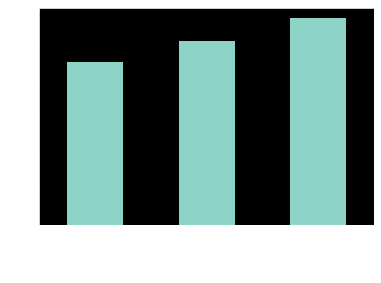

In [ ]:
train_data['sentiment'].value_counts().sort_values().plot(kind='bar')

In [ ]:
# Converting label strings to numeric labels
labels = {'negative': 0, 'positive': 1, 'neutral': 2}
train_data['sentiment'] = train_data['sentiment'].replace(labels)
test_data['sentiment'] = test_data['sentiment'].replace(labels)

train_data['sentence'] = train_data['sentence'].apply(lambda tokens: ' '.join(tokens).strip())
test_data['sentence'] = test_data['sentence'].apply(lambda tokens: ' '.join(tokens).strip())

## Creating Data Loaders

In [ ]:
NUM_WORKERS = 2

# A function to create a data loader given a tokenizer, a sampler, the sentences,
# their labels and the batch size. Sentences are passed in without being tokenized.
# A dataloader providing input ids, attention masks and labels is created
def create_data_loader(tokenizer, sampler, sentences, labels, batch_size):
    encoded = tokenizer(
        text=sentences,
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_multiple_of=8,
        return_tensors='pt',
        padding='longest'
    )

    input_ids = encoded['input_ids']
    attention_masks = encoded['attention_mask']
    labels = tensor(labels)

    dataset = TensorDataset(input_ids, attention_masks, labels)
    return DataLoader(
        dataset, 
        sampler=sampler(dataset),
        batch_size=batch_size, 
        num_workers=NUM_WORKERS
    )

In [ ]:
# Creating data loaders for training and test set
BATCH_SIZE = 96
MODEL_NAME = 'DeepPavlov/bert-base-multilingual-cased-sentence'

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

train_loader = create_data_loader(
    tokenizer, 
    RandomSampler,
    train_data['sentence'].values.tolist(),
    train_data['sentiment'].values,
    batch_size=BATCH_SIZE
)

test_loader = create_data_loader(
    tokenizer, 
    SequentialSampler,
    test_data['sentence'].values.tolist(),
    test_data['sentiment'].values,
    batch_size=BATCH_SIZE
)

## Defining Training & Eval Functions

In [ ]:
# A function to set the random seed value
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [ ]:
# A function to evaluate a model on a data loader
def eval_model(model, loader, device):
    model = model.eval()

    total_loss = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in loader:
            inputs = {
                'input_ids': batch[0].to(device),
                'attention_mask': batch[1].to(device),
                'labels': batch[2].to(device)
            }

            outputs = model(**inputs)

            loss = outputs.loss
            logits = outputs.logits.detach().cpu()
            total_loss += loss.item()

            predictions.append(torch.argmax(logits, dim=1))
            true_labels.append(inputs['labels'].cpu().numpy())

    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)

    return total_loss / len(loader), true_labels, predictions

In [ ]:
# A function to train one epoch of a model on a data loader (tloader)
# and return F1 score of the model on another data loader (dloader)
def train_epoch(model, tloader, dloader, optimizer, scheduler, device):
    model = model.train()

    total_loss = 0
    tqdm_bar = tqdm(tloader)
    for batch in tqdm_bar:
        optimizer.zero_grad()
        inputs = {
            'input_ids': batch[0].to(device),
            'attention_mask': batch[1].to(device),
            'labels': batch[2].to(device)
        }

        outputs = model(**inputs)

        loss = outputs.loss
        logits = outputs.logits
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        tqdm_bar.set_postfix({'TRAINING LOSS': '{:.8f}'.format(loss.item() / len(batch))})

    dev_loss, dev_true_labels, dev_predictions = eval_model(model, dloader, device)
    print(f'AVERAGE TRAINING LOSS: {total_loss / len(tloader)}')
    print(f'AVERAGE TEST LOSS: {dev_loss}')
    print(f'WEIGHTED TEST F1 SCORE: {f1_score(dev_true_labels, dev_predictions, average="weighted")}')

    return f1_score(dev_true_labels, dev_predictions, average='weighted')

## Model Training

In [ ]:
# Training the model
EPOCHS = 4

set_seed(11)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=len(labels), 
    output_attentions=True,
)
model.to(device)

optimizer = Adafactor(
    model.parameters(),
    lr=4e-5,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0.1 * len(train_loader), 
    num_training_steps=EPOCHS * len(train_loader)
)

test_f1 = -math.inf
for epoch in range(EPOCHS):
    hold_f1 = train_epoch(model, train_loader, test_loader, optimizer, scheduler, device)

    if hold_f1 > test_f1:
        torch.save(model.state_dict(), f'{DATA_DIR}/bert_sentimix.bin')
        print(f'FOUND A BEST MODEL WITH TEST DATA F1 SCORE OF {hold_f1}')
        test_f1 = hold_f1
        
del model
del optimizer
del scheduler
torch.cuda.empty_cache()

## Loading Trained Model

In [ ]:
# Loading a trained from GDrive
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_eval = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    output_attentions=False
)

model_eval.to(device)

model_eval.load_state_dict(torch.load(f'{DATA_DIR}/0.7052.bin', map_location=torch.device('cpu')))

In [ ]:
# Calculating Training F1 Score
train_loss, train_true_labels, train_predictions = eval_model(model_eval, train_loader, device)
f1_score(train_true_labels, train_predictions, average='weighted')

In [ ]:
# Calculating Test F1 Score
test_loss, test_true_labels, test_predictions = eval_model(model_eval, test_loader, device)
f1_score(test_true_labels, test_predictions, average='weighted')

In [ ]:
# Printing Test Classification Report
print(classification_report(test_true_labels, test_predictions))

## Generating Answers

In [ ]:
# Generating answer.txt as specified in the event details
labels_inv = {0: 'negative', 1: 'positive', 2: 'neutral'}

with open(f'{DATA_DIR}/answer.txt', 'w') as ofile:
    i = 0
    ofile.write('Uid,Sentiment\n')
    for idx, row in test_data.iterrows():
        ofile.write(f'{idx},{labels_inv[test_predictions[i]]}\n')
        i += 1

## Preprocessing Functions

In [ ]:
# Drop all the text after 'https' substring is encountered
def drop_after_https(text):
    return text.split('https')[0]

In [ ]:
# A function to remove all numbers from the provided text
def remove_numbers(text):
    return ''.join([x for x in text if not x.isdigit()])

In [ ]:
# A function to remove emojis from the provided text
def remove_emojis(text):
    emoji_pattern = re.compile(pattern='['
        "\U0001F600-\U0001F64F"
        "\U0001F300-\U0001F5FF"
        "\U0001F680-\U0001F6FF"
        "\U0001F1E0-\U0001F1FF"
        ']+', flags=re.UNICODE)
    
    return emoji_pattern.sub('', text)

In [ ]:
# Remove all the mentions from the tweets
def remove_mentions(text):
    return re.sub(r'@ \w+', '', text)

In [ ]:
# A function to remove all punctuation from the provided text
def remove_punctuations(text):
    punctuation_pattern = re.compile(pattern='[^\w\s]', flags=re.UNICODE)
    return punctuation_pattern.sub('', text)

In [ ]:
# A function to collapse multiple consecutive whitespaces into one space
def collapse_whitespaces(text):
    whitespaces_pattern = re.compile(pattern='\s+', flags=re.UNICODE)
    return whitespaces_pattern.sub(' ', text)